<a href="https://colab.research.google.com/github/indrawanth/Classification_BERT_EmotionData/blob/main/Emotions_Classification_with_BERT_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Text Mining Emotions Expressions

Build using BERT

2502481043

INDRAWAN HADIANTO

install library transformer

In [ ]:
!pip install transformers datasets scikit-learn



import dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nelgiriyewithana/emotions")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/emotions


In [ ]:
import os

path = "/root/.cache/kagglehub/datasets/nelgiriyewithana/emotions/versions/1"

files_and_directories = os.listdir(path)

print("Files in the directory:")
for item in files_and_directories:
  print(item)

Files in the directory:
text.csv


load dataset

In [ ]:
import pandas as pd

csv_file_name = 'text.csv'

csv_file_path = os.path.join(path, csv_file_name)
if os.path.exists(csv_file_path):
  df = pd.read_csv(csv_file_path)

texts = df['text'].tolist()
labels = df['label'].tolist()

print(f"\nFirst 5 rows of {csv_file_name}:")
display(df.head())

    # label sudah berupa angka, tidak perlu di encode


First 5 rows of text.csv:


,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


split dataset

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=42)


tokenisasi

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=50)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=50)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


cek panjang kalimat untuk menentukan text length

In [ ]:
all_lens = [len(tokenizer.tokenize(t)) for t in texts]
import numpy as np
print("Rata-rata panjang token:", np.mean(all_lens))
print("95th percentile:", np.percentile(all_lens, 95))


Rata-rata panjang token: 20.312133375239018
95th percentile: 43.0


convert to tensorflow dataset untuk training

In [ ]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
)).batch(32)


load pretrained BERT

In [ ]:
from transformers import TFBertForSequenceClassification

# dense layer
num_labels = len(set(labels))
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


compile model

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=2
)


Epoch 1/2
10421/10421 [==============================] - 722s 65ms/step - loss: 0.1353 - accuracy: 0.9296 - val_loss: 0.0975 - val_accuracy: 0.9393
Epoch 2/2
10421/10421 [==============================] - 654s 63ms/step - loss: 0.0930 - accuracy: 0.9408 - val_loss: 0.0959 - val_accuracy: 0.9394


Evaluasi Model

In [ ]:
import numpy as np

y_pred_logits = model.predict(val_dataset).logits
y_pred = np.argmax(y_pred_logits, axis=1)

y_true = []
for _, label in val_dataset.unbatch():
    y_true.append(label.numpy())


2606/2606 [==============================] - 67s 24ms/step


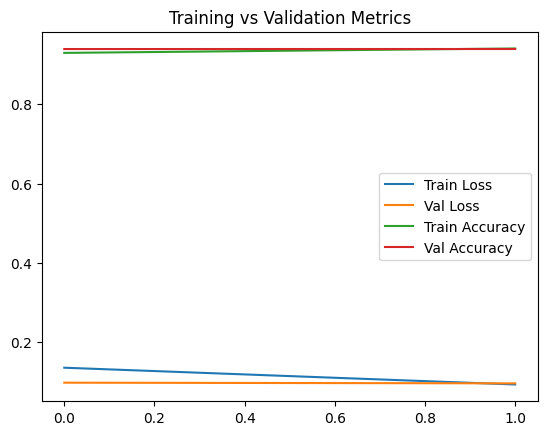

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Training vs Validation Metrics")
plt.show()


loss & accuracy

In [ ]:
model.evaluate(val_dataset)
model.save_pretrained("bert_emotion_model")
tokenizer.save_pretrained("bert_emotion_model")


2606/2606 [==============================] - 64s 25ms/step - loss: 0.0959 - accuracy: 0.9394


('bert_emotion_model/tokenizer_config.json',
 'bert_emotion_model/special_tokens_map.json',
 'bert_emotion_model/vocab.txt',
 'bert_emotion_model/added_tokens.json')

accuracy, precision, recall, F1 Score

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy :", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average='macro'))
print("Recall   :", recall_score(y_true, y_pred, average='macro'))
print("F1 Score :", f1_score(y_true, y_pred, average='macro'))


Accuracy : 0.9394448309781435
Precision: 0.9262214325083531
Recall   : 0.896982212441309
F1 Score : 0.9042041679885732


TESTING BIKIN PREDIKSI

In [ ]:
# Gunakan bahasa Inggris kalau mau melakukan prediksi kelas, karena data yang ditraining pake bahasa Inggris

text = "I'm very happy today" # buat tes prediksi masukin kata-kata di sini pake bahasa Inggris


inputs = tokenizer(text, return_tensors="tf", truncation=True, padding=True)
outputs = model(inputs)
pred_label = tf.argmax(outputs.logits, axis=1).numpy()[0]
print("Prediksi kelas:", le.inverse_transform([pred_label])[0])


Prediksi kelas: 1


In [ ]:
 # keterangan kelas
  #      0: 'sedih',
  #      1: 'senang',
  #      2: 'cinta',
  #      3: 'marah',
  #      4: 'takut',
  #      5: 'kaget'